# myAOAnet

In [1]:
import os
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, accuracy_score
%matplotlib inline

## IQ data visualization

In [359]:
data_from = 'data_1607'

In [360]:
iq_data0 = pd.read_csv(join(data_from, 'iq_example', 'log_long.csv'), sep=',', header=0)

In [361]:
iq_data = iq_data0.drop(iq_data0.columns[[index for index in range(11)]], axis = 1, inplace = False)
iq_data.shape

(20, 262144)

In [362]:
iq_data[abs(iq_data['field.data0']) >= 5e-4]

,field.data0,field.data1,field.data2,field.data3,field.data4,field.data5,field.data6,field.data7,field.data8,field.data9,...,field.data262134,field.data262135,field.data262136,field.data262137,field.data262138,field.data262139,field.data262140,field.data262141,field.data262142,field.data262143
9,0.001527,-0.003788,0.005097,-0.003052,0.005017,0.002400,-0.000642,0.006226,-0.006323,0.002599,...,-0.014155,0.256926,0.201750,0.175355,0.246552,-0.041530,0.102466,-0.214767,-0.063022,-0.218912
10,0.003459,0.001882,0.006306,0.000047,0.004872,-0.004291,-0.000818,-0.006727,-0.006143,-0.003759,...,-0.248658,0.021835,-0.245199,-0.027823,-0.236808,-0.102429,-0.210182,-0.176252,-0.148430,-0.184946
11,-0.001152,0.003188,-0.002736,0.005617,-0.004219,0.005804,-0.005345,0.004041,-0.006146,0.002112,...,0.089025,-0.216949,0.230015,0.012959,0.083313,0.202702,-0.146516,0.129018,-0.199031,-0.067198
12,-0.003960,0.001378,-0.005592,-0.002246,-0.001146,-0.005698,0.005152,-0.003264,0.005057,0.003557,...,-0.030675,0.216316,-0.206377,0.017056,-0.082283,-0.191304,0.146881,-0.121229,0.186264,0.092819
13,0.004742,0.000788,0.003815,0.004947,-0.002572,0.004804,-0.005905,-0.001488,-0.000621,-0.006125,...,0.140500,-0.201191,-0.050611,-0.248188,-0.199732,-0.119786,-0.207905,0.079688,-0.105167,0.180666
14,-0.001009,-0.003642,-0.004239,-0.004469,-0.006669,-0.000767,-0.005375,0.004870,-0.000408,0.007409,...,-0.033021,0.234319,-0.223229,0.076096,-0.172582,-0.142421,0.044226,-0.203057,0.184921,-0.095771
16,-0.003605,0.001528,-0.003665,0.005375,0.001179,0.006902,0.006703,0.002934,0.006770,-0.004100,...,-0.010363,0.069202,0.065200,0.016588,0.014054,-0.081609,-0.082781,-0.031586,-0.041106,0.117936
17,0.000705,0.005479,0.003786,0.002088,0.001485,-0.002654,-0.002415,-0.001758,-0.001586,0.001972,...,0.025908,-0.253184,-0.167310,-0.204896,-0.246973,-0.021512,-0.173746,0.166842,-0.040910,0.219033
18,-0.002505,-0.003336,-0.006140,-0.003410,-0.007429,0.000760,-0.004372,0.006128,0.001497,0.007961,...,0.000111,-0.001228,-0.000436,-0.002350,-0.000964,-0.003523,-0.000995,-0.002368,-0.000962,0.000240


In [363]:
sample_id = 18
iq_data_np = iq_data.to_numpy()[sample_id, :]

In [364]:
iq_arr = iq_data_np.reshape(4, 32768, 2)

Text(0.5, 1.0, 'Imag part of IQ chn0')

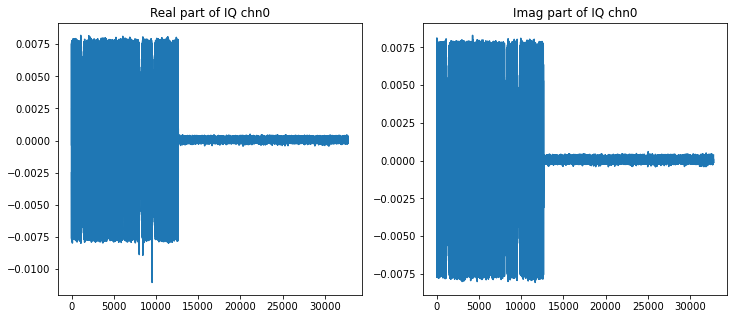

In [365]:
chn = 0

fig0 ,ax0 = plt.subplots(1, 2,figsize=(12,5))
ax0[0].plot(iq_arr[chn, :, 0])
ax0[0].set_title("Real part of IQ chn0")
ax0[1].plot(iq_arr[chn, :, 1])
ax0[1].set_title("Imag part of IQ chn0")
#plt.show()

In [366]:
iq_amp = np.zeros((32768, 4))
iq_amp = np.sqrt(iq_arr[:, :, 0]**2 + iq_arr[:, :, 1]**2)
iq_amp.shape

(4, 32768)

In [367]:
iq_phase2 = np.zeros((32768, 4))
iq_phase2 = np.angle(iq_arr[:, :, 0] + iq_arr[:, :, 1]*1j)
iq_phase2.shape

(4, 32768)

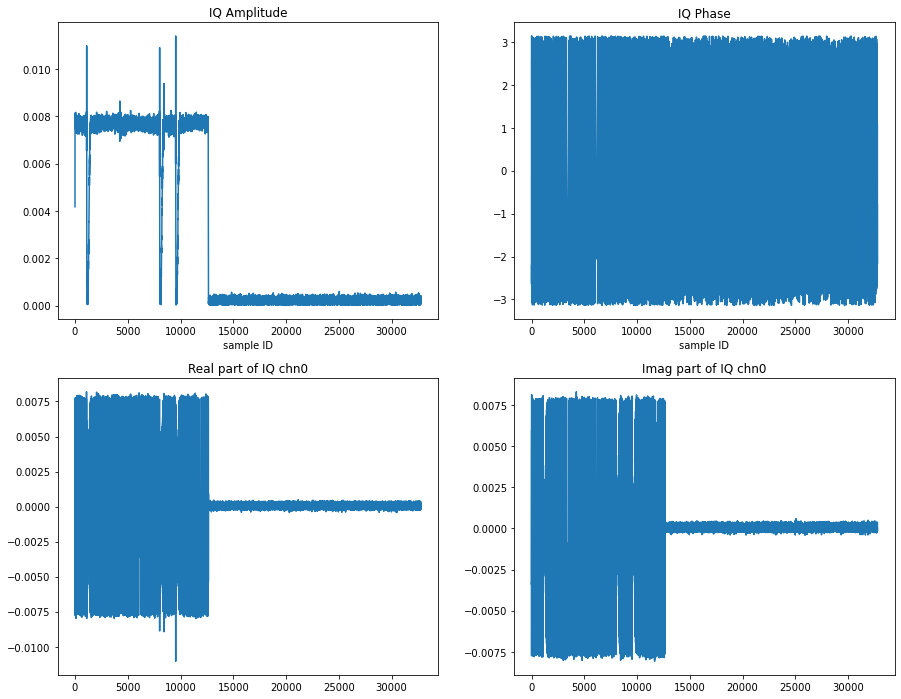

In [368]:
fig ,ax = plt.subplots(2, 2,figsize=(15,12))
ax[0,0].plot(iq_amp[chn, :])
ax[0,0].set_title("IQ Amplitude")
ax[0,0].set_xlabel("sample ID")
ax[0,1].plot(iq_phase2[chn, :])
ax[0,1].set_title("IQ Phase")
ax[0,1].set_xlabel("sample ID")

ax[1,0].plot(iq_arr[chn, :, 0])
ax[1,0].set_title("Real part of IQ chn0")
ax[1,1].plot(iq_arr[chn, :, 1])
ax[1,1].set_title("Imag part of IQ chn0")

plt.show()

In [369]:
fig.savefig(join('doc', '{data_from}-{samp_id}-{chn}'.format(data_from=data_from, samp_id=sample_id, chn=chn)), \
           facecolor="w", bbox_inches='tight')

## R-AOA Dataframe

In [254]:
data_dir = 'data_1606'
aoa_dict = {}
#fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

for filename in os.listdir(data_dir):
    if filename.startswith("deg_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[- float(filename[5:-4])] = aoa_Rjk
    elif filename.startswith("deg_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [255]:
num_fields = aoa_dict[0].shape[1]
aoa_dict[70].iloc[:55]

,field.data0,field.data1,field.data2,field.data3,field.data4,field.data5,field.data6,field.data7,field.data10,field.data11,field.data12,field.data13,field.data14,field.data15,field.data20,field.data21,field.data22,field.data23,field.data30,field.data31
0,7.526392e-08,0.0,2.490040e-08,-2.405121e-09,-3.484437e-08,-3.063703e-08,3.226090e-09,-8.633423e-08,0.000004,0.0,-1.431086e-07,-8.721196e-08,1.082867e-08,-2.937434e-07,0.000005,0.0,4.024799e-07,4.311856e-07,0.000005,0.0
1,7.560359e-08,0.0,2.483647e-08,-1.342088e-09,-3.719919e-08,-2.796628e-08,8.889444e-09,-7.924728e-08,0.000004,0.0,-1.213265e-07,-1.231836e-07,4.405316e-08,-3.308355e-07,0.000005,0.0,3.660803e-07,4.611191e-07,0.000005,0.0
2,7.669845e-08,0.0,2.745596e-08,7.508641e-10,-3.573456e-08,-3.751554e-08,1.567188e-09,-7.940065e-08,0.000004,0.0,-9.603728e-08,-1.676394e-07,6.486814e-08,-3.118463e-07,0.000005,0.0,4.271776e-07,5.061634e-07,0.000005,0.0
3,1.640777e-04,0.0,6.178386e-04,1.540806e-03,-7.417114e-04,6.609720e-04,-1.300554e-04,-1.928160e-03,0.016815,0.0,3.414758e-03,9.453853e-03,-1.859993e-02,-6.039345e-03,0.006026,0.0,-7.184598e-03,9.246820e-03,0.022795,0.0
4,2.627889e-03,0.0,1.087553e-02,2.436308e-02,-1.230657e-02,1.018483e-02,-1.049482e-03,-3.126499e-02,0.271405,0.0,4.343495e-02,1.559329e-01,-2.938511e-01,-1.195037e-01,0.097326,0.0,-1.164169e-01,1.507003e-01,0.372969,0.0
5,2.418420e-03,0.0,1.008090e-02,2.243513e-02,-1.137797e-02,9.540075e-03,-7.688365e-04,-2.944440e-02,0.250610,0.0,4.101777e-02,1.450436e-01,-2.760412e-01,-1.154513e-01,0.091365,0.0,-1.126927e-01,1.417501e-01,0.359202,0.0
6,2.184686e-03,0.0,9.085534e-03,2.026233e-02,-1.026203e-02,8.812762e-03,-2.039278e-04,-2.695499e-02,0.226164,0.0,3.900624e-02,1.315659e-01,-2.505474e-01,-1.100605e-01,0.083941,0.0,-1.079133e-01,1.276132e-01,0.332921,0.0
7,2.245222e-03,0.0,9.336000e-03,2.083942e-02,-1.057272e-02,9.137580e-03,1.371210e-04,-2.736480e-02,0.232710,0.0,4.079616e-02,1.358610e-01,-2.531234e-01,-1.149122e-01,0.087165,0.0,-1.121587e-01,1.284728e-01,0.333877,0.0
8,2.053974e-03,0.0,8.489923e-03,1.902940e-02,-9.779181e-03,8.305892e-03,3.012588e-04,-2.518566e-02,0.211761,0.0,3.648953e-02,1.247155e-01,-2.318513e-01,-1.067719e-01,0.080307,0.0,-1.033993e-01,1.188466e-01,0.309130,0.0
9,2.053675e-03,0.0,8.443018e-03,1.912339e-02,-9.860627e-03,8.302481e-03,3.461379e-04,-2.522890e-02,0.213201,0.0,3.672418e-02,1.257009e-01,-2.332225e-01,-1.068066e-01,0.081096,0.0,-1.037919e-01,1.199182e-01,0.310292,0.0


(1) Update R filtering threshold

In [256]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-05

# List of data.fields used in filtering
fields_filter_lst = ['field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data22', 'field.data23']

for key in aoa_dict.keys():
    print("%s shape of signal-presenting snapshots = %.01f" % (str(aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(aoa_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data23']) >= field_thres)].shape), key))

(225, 21) shape of signal-presenting snapshots = 0.0
(248, 21) shape of signal-presenting snapshots = 60.0
(192, 21) shape of signal-presenting snapshots = -50.0
(237, 21) shape of signal-presenting snapshots = -60.0
(180, 21) shape of signal-presenting snapshots = -40.0
(203, 21) shape of signal-presenting snapshots = 20.0
(226, 21) shape of signal-presenting snapshots = 70.0
(215, 21) shape of signal-presenting snapshots = 40.0
(187, 21) shape of signal-presenting snapshots = 30.0
(267, 21) shape of signal-presenting snapshots = -30.0
(215, 21) shape of signal-presenting snapshots = -70.0
(222, 21) shape of signal-presenting snapshots = -20.0
(256, 21) shape of signal-presenting snapshots = 10.0
(257, 21) shape of signal-presenting snapshots = -10.0
(230, 21) shape of signal-presenting snapshots = 50.0


/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [257]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
sig_index_lst = {}

for key in aoa_dict.keys():
    aoa_sig[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data2']) < field_thres].index)
    aoa_noi[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data2']) >= field_thres].index)
    
    sig_index_lst[key] = (aoa_dict[key][abs(aoa_dict[key]['field.data2']) >= field_thres].index)
    
sig_index_lst[-10]

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
            ...
            805, 806, 807, 808, 809, 810, 811, 812, 813, 814],
           dtype='int64', length=259)

In [258]:
# Save sig_index!
import pickle

with open(join(data_dir, 'df_collection', 'sig_index.pkl'), "wb") as a_file:
    pickle.dump(sig_index_lst, a_file)

In [6]:
# Load sig index
import pickle

with open(join(data_dir, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
    sig_index_lst = pickle.load(a_file)

In [259]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
idx = pd.IndexSlice

In [260]:
print(Xaoa.shape)
Xaoa.loc[idx[[-10, 0, 30, 70], :], :]
Xaoa

(3386, 21)


field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         0          0.000046          0.0     0.002728     0.000348   
            1          0.000032          0.0     0.002230     0.000289   
            2          0.000008          0.0     0.000627     0.000079   
            27         0.000004          0.0     0.000310     0.000150   
            28         0.000120          0.0    -0.000454    -0.003152   
...                         ...          ...          ...          ...   
 70         707        0.002506          0.0     0.003383     0.023918   
            708        0.002359          0.0     0.003174     0.022460   
            709        0.001897          0.0     0.002347     0.017940   
            710        0.001451          0.0     0.001547     0.013673   
            711        0.000982          0.0     0.000807     0.009173   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         0          0.001615    -0.000416     0.001171    -0.000044   
            1          0.001354    -0.000339     0.001016    -0.000039   
            2          0.000384    -0.000098     0.000293    -0.000017   
            27         0.000223     0.000034     0.000113     0.000085   
            28        -0.000799    -0.001858     0.000271    -0.001878   
...                         ...          ...          ...          ...   
 70         707       -0.016969     0.003560     0.009624    -0.030561   
            708       -0.016128     0.003234     0.009060    -0.029390   
            709       -0.013109     0.002452     0.008144    -0.025374   
            710       -0.010135     0.001830     0.006969    -0.020548   
            711       -0.006896     0.001067     0.005356    -0.014184   

                    field.data10  field.data11  ...  field.data13  \
Series name Row ID                              ...                 
-70         0           0.165659           0.0  ...     -0.037592   
            1           0.161718           0.0  ...     -0.037243   
            2           0.050502           0.0  ...     -0.011764   
            27          0.028097           0.0  ...     -0.005342   
            28          0.165926           0.0  ...     -0.029510   
...                          ...           ...  ...           ...   
 70         707         0.233392           0.0  ...      0.166462   
            708         0.218569           0.0  ...      0.157591   
            709         0.172999           0.0  ...      0.126773   
            710         0.130789           0.0  ...      0.097287   
            711         0.086527           0.0  ...      0.065134   

                    field.data14  field.data15  field.data20  field.data21  \
Series name Row ID                                                           
-70         0           0.069720     -0.011793      0.061505           0.0   
            1           0.072078     -0.012540      0.062923           0.0   
            2           0.023049     -0.004381      0.020062           0.0   
            27          0.011273      0.002239      0.011953           0.0   
            28          0.082327      0.023186      0.068399           0.0   
...                          ...           ...           ...           ...   
 70         707        -0.278442     -0.132870      0.120211           0.0   
            708        -0.267317     -0.125657      0.114910           0.0   
            709        -0.229677     -0.108304      0.093950           0.0   
            710        -0.186047     -0.087480      0.073229           0.0   
            711        -0.127907     -0.061592      0.049657           0.0   

                    field.data22  field.data23  field.data30  field.data31  \
Series name Row ID                                                           
-70         0           0

In [261]:
# Save raw X
Xaoa.to_csv(join(data_dir, 'df_collection', 'Xraw.csv'), index=True, header=True)

### MUSIC

In [262]:
# Notice Noisy Rosbags do not contain 'kerberos/doa_results'
#data_dir = 'data_0107'
music_dict = {}

for filename in os.listdir(data_dir):
    if filename.startswith("music_deg_m") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[- float(filename[11:-4])] = music_series
    elif filename.startswith("music_deg_") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[float(filename[10:-4])] = music_series

In [263]:
for key in music_dict.keys():
    music_dict[key] = music_dict[key][sig_index_lst[key]]

In [264]:
# Add MUSIC_results as 22nd column
Xmusic = pd.concat([music_dict[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
Xaoa_music = pd.concat([Xaoa, Xmusic], axis=1)
Xaoa_music

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         0          0.000046          0.0     0.002728     0.000348   
            1          0.000032          0.0     0.002230     0.000289   
            2          0.000008          0.0     0.000627     0.000079   
            27         0.000004          0.0     0.000310     0.000150   
            28         0.000120          0.0    -0.000454    -0.003152   
...                         ...          ...          ...          ...   
 70         707        0.002506          0.0     0.003383     0.023918   
            708        0.002359          0.0     0.003174     0.022460   
            709        0.001897          0.0     0.002347     0.017940   
            710        0.001451          0.0     0.001547     0.013673   
            711        0.000982          0.0     0.000807     0.009173   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         0          0.001615    -0.000416     0.001171    -0.000044   
            1          0.001354    -0.000339     0.001016    -0.000039   
            2          0.000384    -0.000098     0.000293    -0.000017   
            27         0.000223     0.000034     0.000113     0.000085   
            28        -0.000799    -0.001858     0.000271    -0.001878   
...                         ...          ...          ...          ...   
 70         707       -0.016969     0.003560     0.009624    -0.030561   
            708       -0.016128     0.003234     0.009060    -0.029390   
            709       -0.013109     0.002452     0.008144    -0.025374   
            710       -0.010135     0.001830     0.006969    -0.020548   
            711       -0.006896     0.001067     0.005356    -0.014184   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         0           0.165659           0.0  ...      0.069720   
            1           0.161718           0.0  ...      0.072078   
            2           0.050502           0.0  ...      0.023049   
            27          0.028097           0.0  ...      0.011273   
            28          0.165926           0.0  ...      0.082327   
...                          ...           ...  ...           ...   
 70         707         0.233392           0.0  ...     -0.278442   
            708         0.218569           0.0  ...     -0.267317   
            709         0.172999           0.0  ...     -0.229677   
            710         0.130789           0.0  ...     -0.186047   
            711         0.086527           0.0  ...     -0.127907   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-70         0          -0.011793      0.061505           0.0      0.042218   
            1          -0.012540      0.062923           0.0      0.044782   
            2          -0.004381      0.020062           0.0      0.014547   
            27          0.002239      0.011953           0.0      0.006618   
            28          0.023186      0.068399           0.0      0.046785   
...                          ...           ...           ...           ...   
 70         707        -0.132870      0.120211           0.0     -0.108666   
            708        -0.125657      0.114910           0.0     -0.102326   
            709        -0.108304      0.093950           0.0     -0.089175   
            710        -0.087480      0.073229           0.0     -0.074644   
            711        -0.061592      0.049657           0.0     -0.053037   

                    field.data23  field.data30  field.data31    theta  music  
Series name Row ID                                                            
-70         0          

In [265]:
print(data_dir)
Xmusic.to_csv(join(data_dir, 'df_collection', 'music_series.csv'), index=True, header=True)

data_1606


In [266]:
Xaoa_music.to_csv(join(data_dir, 'df_collection', 'Xaoa_music.csv'), index=True, header=True)

## Create Origin-Noisy-MUSIC dataset

In [267]:
#field_thres = 1e-05

def create_dataset(dirname, sigma, Xmusic, sig_index_lst):
    aoa_dict = {}
    #fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
    fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
                  'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
                  'field.data20', 'field.data21', 'field.data22', 'field.data23', \
                  'field.data30', 'field.data31']

    for filename in os.listdir(dirname):
        #print(join(dirname, filename))
        if filename.startswith("deg_m") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(dirname, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- float(filename[5:-9])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(dirname, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[float(filename[4:-9])] = aoa_Rjk
    
    aoa_sig, aoa_noi = {}, {}
    #sig_index_lst = {}
            
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180
        #print(key ,aoa_dict[key].shape)
        #print(sig_index_lst[key])
        
        # Patch: cut positional idx that are out-of-bound
        #slice_idx = sig_index_lst[key]
        #slice_idx = slice_idx[slice_idx<len(sig_index_lst[key])]
        try:
            aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key], :]
        except IndexError:
            aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key][:-3], :]
    
    Xaoa_noi = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], \
                     keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
    
    Xaoa_noi_music = pd.concat([Xaoa_noi, Xmusic], axis=1)
    return Xaoa_noi_music
    

In [268]:
# trick: slice pd.Int64Index
sig_index_lst[10][:-1]

Int64Index([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
            ...
            853, 854, 855, 856, 857, 858, 859, 860, 861, 862],
           dtype='int64', length=256)

In [269]:
import pickle

noi_dir_lst = ['noisy1', 'noisy2', 'noisy3', 'noisy4', 'noisy5']
#noi_dir_lst = []

def get_X_list(dirname):
    Xaoa_music = pd.read_csv(join(dirname, 'df_collection', 'Xaoa_music.csv'), index_col=[0, 1])
    Xnoisy_parts = [Xaoa_music]
    with open(join(dirname, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
        sig_index_lst = pickle.load(a_file)
        
    Xmusic = pd.read_csv(join(dirname, 'df_collection', 'music_series.csv'), index_col=[0, 1])
    
    for noi_dir in noi_dir_lst:
        noisy_dir = join(dirname, noi_dir)
        
        Xnoisy_parts.append(create_dataset(noisy_dir, '1e_5', Xmusic, sig_index_lst))
        Xnoisy_parts.append(create_dataset(noisy_dir, '5e_5', Xmusic, sig_index_lst))
        Xnoisy_parts.append(create_dataset(noisy_dir, '1e_4', Xmusic, sig_index_lst))
        Xnoisy_parts.append(create_dataset(noisy_dir, '5e_4', Xmusic, sig_index_lst))

    return Xnoisy_parts

X_1607 = get_X_list('data_1607')  # NLOS interior-to-outdoor
X_1407 = get_X_list('data_1407')  # LOS open with reflector
#'''
X_0207 = get_X_list('data_0207')  # NLOS corridor
X_0107 = get_X_list('data_0107')  # NLOS office
X_1606 = get_X_list('data_1606')  # LOS open area
#'''

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [270]:
X =  X_0107 + X_1407 + X_1607
X1 = X_1606 + X_0207
#X1 = Xaoa_music

print(len(X))
X[0].head(20)

63


field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         0          0.002188          0.0     0.001808     0.029411   
            1          0.002179          0.0     0.000861     0.029395   
            2          0.002176          0.0    -0.000328     0.029413   
            3          0.002171          0.0    -0.001383     0.029345   
            4          0.002175          0.0    -0.001364     0.029368   
            5          0.002172          0.0     0.000975     0.029305   
            6          0.002182          0.0     0.002705     0.029356   
            7          0.001605          0.0    -0.000111     0.021923   
            33         0.001664          0.0     0.000253     0.022867   
            34         0.002153          0.0     0.000760     0.029569   
            35         0.002160          0.0     0.001835     0.029543   
            36         0.002147          0.0     0.002909     0.029250   
            37         0.002147          0.0     0.003500     0.029170   
            38         0.002167          0.0     0.004087     0.029299   
            39         0.002139          0.0     0.004229     0.028915   
            40         0.002148          0.0     0.004371     0.029066   
            41         0.002148          0.0     0.003647     0.029165   
            42         0.002109          0.0     0.002692     0.028735   
            67         0.000742          0.0    -0.000873     0.010173   
            68         0.002147          0.0    -0.002111     0.029457   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         0         -0.025601    -0.020081     0.000433    -0.029340   
            1         -0.025428    -0.020032     0.002220    -0.029285   
            2         -0.025837    -0.019418     0.002579    -0.029249   
            3         -0.025882    -0.019281     0.002864    -0.029214   
            4         -0.026288    -0.018788     0.003310    -0.029146   
            5         -0.026352    -0.018684     0.002425    -0.029138   
            6         -0.027470    -0.016962    -0.001136    -0.029599   
            7         -0.020317    -0.012640    -0.001230    -0.022001   
            33        -0.022321    -0.010911    -0.004088    -0.022539   
            34        -0.029000    -0.013752    -0.006157    -0.029036   
            35        -0.029398    -0.012867    -0.007211    -0.028809   
            36        -0.029760    -0.011440    -0.008128    -0.028347   
            37        -0.030048    -0.010684    -0.008960    -0.028073   
            38        -0.030495    -0.010010    -0.009516    -0.028163   
            39        -0.030196    -0.009557    -0.009252    -0.027878   
            40        -0.030399    -0.009623    -0.008328    -0.028324   
            41        -0.030084    -0.010520    -0.006702    -0.028805   
            42        -0.029060    -0.011643    -0.004785    -0.028659   
            67        -0.008908    -0.006705    -0.000221    -0.010248   
            68        -0.026145    -0.018798    -0.000329    -0.029700   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         0           0.403125           0.0  ...     -0.392936   
            1           0.402732           0.0  ...     -0.392514   
            2           0.402633           0.0  ...     -0.394203   
            3           0.401540           0.0  ...     -0.395207   
            4           0.401403           0.0  ...     -0.394017   
            5           0.401376           0.0  ...     -0.390853   
            6           0.405571           0.0  ...     -0.398093   
            7           0.303657           0.0  ...     -0.299548   
            33          0.318474           0.0  ...     -0.309905   
   

Use Rij phase as input feature

In [22]:
#new_col = ['r11', 'r12', 'r13', 'r14', 'r22', 'r23', 'r24', 'r33', 'r34', 'r44']
new_col = ['r12', 'r13', 'r14', 'r23', 'r24', 'r34']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
                  'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
                  'field.data20', 'field.data21', 'field.data22', 'field.data23', \
                  'field.data30', 'field.data31']

def create_Xphs_Xamp(X):
    Xdata = X[fields_lst]
    Xnew = X.drop(fields_lst, axis=1)
    Xamp = Xnew.copy(deep=True)
    
    for i, col in enumerate(new_col):
        
        val = np.angle(Xdata.iloc[:, 2*i] + 1j*Xdata.iloc[:, 2*i+1])
        Xnew.insert(loc=i, column=col, value=val)
        
        amp = np.sqrt(Xdata.iloc[:, 2*i]**2 + Xdata.iloc[:, 2*i+1]**2)
        Xamp.insert(loc=i, column=col, value=amp)
        
    return Xnew, Xamp

In [23]:
# R_Phase diagonal components are 0s!
Xphs, Xamp = [], []
for item in X:
    phs, amp = create_Xphs_Xamp(item)
    Xphs.append(phs)
    Xamp.append(amp)

In [25]:
Xphs1, Xamp1 = [], []
for item in [X1]:
    phs, amp = create_Xphs_Xamp(item)
    Xphs1.append(phs)
    Xamp1.append(amp)

In [26]:
print(len(Xphs1))
Xphs1[0].head()

1


r12       r13       r14       r23  r24       r34    theta  \
Series name Row ID                                                              
-70         78      0.0  1.095544  2.266548 -1.749899  0.0  1.170685 -1.22173   
            79      0.0  1.087855  2.260238 -1.760678  0.0  1.172099 -1.22173   
            80      0.0  1.082444  2.258157 -1.767579  0.0  1.175412 -1.22173   
            81      0.0  1.085134  2.259445 -1.762106  0.0  1.174003 -1.22173   
            82      0.0  1.080380  2.250121 -1.762131  0.0  1.169443 -1.22173   

                    music  
Series name Row ID         
-70         78      326.0  
            79      332.0  
            80      332.0  
            81      332.0  
            82      332.0

In [115]:
# Save 'Xphs' of Rjk instead
import pickle

with open(join('Data', 'pureXphs.pkl'), 'wb') as a_file:
    pickle.dump(Xphs, a_file)

In [116]:
# Save Real & Image parts of Rjk
with open(join('Data', 'pureX.pkl'), 'wb') as a_file:
    pickle.dump(X, a_file)

In [65]:
# Save Real & Image parts of Rjk of all datasets
with open(join('Data', 'X_105.pkl'), 'wb') as a_file:
    pickle.dump(X, a_file)

### Save/Load .pkl to a list of DataFrame

In [2]:
# Load X (a list)
import pickle

with open(join('Data', 'Xphs.pkl'), 'rb') as a_file:
    Xphs = pickle.load(a_file)
    
with open(join('Data', 'X_105.pkl'), 'rb') as a_file:
    X = pickle.load(a_file)

In [5]:
import pickle
'''
df_lst = []
sig_idx_lst = []
load_lst = ['data_1606', 'data_0107', 'data_0207']

for load_dir in load_lst:
    for filename in os.listdir(join(load_dir, 'df_collection')):
        if filename.startswith("LOS") and filename.endswith("ALL.csv"):
            print(load_dir, filename)
            Xaoa0 = pd.read_csv(join(load_dir, 'df_collection', filename), index_col=[0, 1])
            df_lst.append(Xaoa0)
            with open(join(load_dir, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
                sig_idx_lst.append(pickle.load(a_file))
'''

len(X)

105

In [4]:
# Use R_phase as input instead
'''
df_lst = []
load_lst = ['data_1606', 'data_0107', 'data_0207']

for load_dir in load_lst:
    for filename in os.listdir(join(load_dir, 'df_collection')):
        if filename.startswith("PHS_LOS") and filename.endswith("ALL.csv"):
            print(load_dir, filename)
            Xaoa0 = pd.read_csv(join(load_dir, 'df_collection', filename), index_col=[0, 1])
            df_lst.append(Xaoa0)
'''

'\ndf_lst = []\nload_lst = [\'data_1606\', \'data_0107\', \'data_0207\']\n\nfor load_dir in load_lst:\n    for filename in os.listdir(join(load_dir, \'df_collection\')):\n        if filename.startswith("PHS_LOS") and filename.endswith("ALL.csv"):\n            print(load_dir, filename)\n            Xaoa0 = pd.read_csv(join(load_dir, \'df_collection\', filename), index_col=[0, 1])\n            df_lst.append(Xaoa0)\n'

In [6]:
# Slicing Example
idx = pd.IndexSlice
X[0].loc[idx[-30, :20], :]

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-30         4          0.004537          0.0     0.019305    -0.010193   
            5          0.007078          0.0     0.030401    -0.016007   
            6          0.007035          0.0     0.030353    -0.015765   
            7          0.007096          0.0     0.030577    -0.015770   
            8          0.007042          0.0     0.030518    -0.015511   
            9          0.007052          0.0     0.030552    -0.015541   
            10         0.007049          0.0     0.030387    -0.015734   
            11         0.007076          0.0     0.030488    -0.015709   
            12         0.006998          0.0     0.030128    -0.015725   
            13         0.007087          0.0     0.030281    -0.016114   
            14         0.000779          0.0     0.003335    -0.001752   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-30         4         -0.008209     0.000556    -0.014722     0.010581   
            5         -0.013366     0.001186    -0.024114     0.017374   
            6         -0.013744     0.001671    -0.024870     0.018445   
            7         -0.014181     0.002197    -0.025630     0.019559   
            8         -0.014187     0.002329    -0.025864     0.019582   
            9         -0.013987     0.002054    -0.025796     0.019076   
            10        -0.013990     0.001606    -0.025913     0.018328   
            11        -0.013824     0.001449    -0.025552     0.017951   
            12        -0.013351     0.000735    -0.024636     0.016547   
            13        -0.012895     0.000175    -0.023782     0.015731   
            14        -0.001369     0.000010    -0.002531     0.001696   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-30         4           0.106066           0.0  ...     -0.086929   
            5           0.168295           0.0  ...     -0.143603   
            6           0.167899           0.0  ...     -0.149522   
            7           0.168429           0.0  ...     -0.154849   
            8           0.168021           0.0  ...     -0.156165   
            9           0.168222           0.0  ...     -0.154735   
            10          0.167720           0.0  ...     -0.153520   
            11          0.167807           0.0  ...     -0.150802   
            12          0.166609           0.0  ...     -0.144045   
            13          0.167590           0.0  ...     -0.138187   
            14          0.018422           0.0  ...     -0.014758   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-30         4           0.012012      0.015093           0.0      0.028198   
            5           0.020189      0.025719           0.0      0.048879   
            6           0.023982      0.027561           0.0      0.053468   
            7           0.027481      0.029348           0.0      0.057813   
            8           0.028044      0.029681           0.0      0.059124   
            9           0.025939      0.028662           0.0      0.057251   
            10          0.021290      0.028449           0.0      0.056121   
            11          0.020733      0.027611           0.0      0.054088   
            12          0.015974      0.025852           0.0      0.049208   
            13          0.013221      0.023735           0.0      0.044078   
            14          0.001581      0.002440           0.0      0.004517   

                    field.data23  field.data30  field.data31     theta  music  
Series name Row ID                                                             
-30         4        

## Preparation

### Create training data with Clean & Noisy datasets

In [271]:
def Split_TimeSeries3(Xaoa, aoa_gt_series=range(-70, 80, 10), feature_space=20):
    # Xarr: time series of Rjk
    Xaoa_cpy = Xaoa.copy(deep=True)

    Xarr, ylst = np.empty((0, 3, feature_space), dtype='float32'), []
    rowt_0, rowt_1, rowt_2 = None, None, None
    row_up, row_mid, row_down = -1, -1, -1

    for serName in aoa_gt_series:
        isFirstRow = True
        isSecRow = True
        for rowId, row in Xaoa_cpy.loc[serName].iterrows():
            row_up = row_mid
            rowt_2 = rowt_1
            row_mid = row_down
            rowt_1 = rowt_0
            row_down = rowId
            
            rowt_0 = row.drop(['theta', 'music']).to_numpy(dtype='float32').reshape(1, 1, feature_space)
            # Normalization!
            rowt_0 = rowt_0/np.linalg.norm(rowt_0)
            #print(rowt_0)
            
            if isFirstRow:
                isFirstRow = False
                continue

            if isSecRow:
                isSecRow = False
                continue

            if row_down-row_mid==1 and row_mid-row_up==1:
                arr_tmp = np.concatenate((rowt_2, rowt_1, rowt_0), axis=1)

                Xarr = np.append(Xarr, arr_tmp, axis=0)
                ylst.append([row['theta'], row['music']])

    # Xvec: slice of a Rjk row
    Xvec = Xaoa_cpy.drop(['theta', 'music'], axis=1).to_numpy()
    yvec = Xaoa_cpy[['theta', 'music']].to_numpy()
                
    #print(Xarr.shape, len(ylst))
    return Xarr, ylst, Xvec, yvec

Convert Clean & Noisy Dataframes into Numpy.Array where (3) coherent snapshots should be grouped

In [272]:
# Use R_(real,imag) as input features
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in X:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(150045, 3, 20)
(150045, 2)
(186837, 20)
(186837, 2)


In [273]:
# Use R_xx of unseen X1 as input features
Xarr1 = np.array([])
yarr1 = np.array([])
Xvec1 = np.array([])
yvec1 = np.array([])

for item in X1:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=20)
    
    Xarr1 = np.concatenate((Xarr1, Xarr0), axis=0) if Xarr1.size else Xarr0
    Xvec1 = np.concatenate((Xvec1, Xvec0), axis=0) if Xvec1.size else Xvec0
    yvec1 = np.concatenate((yvec1, yvec0), axis=0) if yvec1.size else yvec0
    yarr0 = np.array(ylst0)
    yarr1 = np.concatenate((yarr1, yarr0), axis=0) if yarr1.size else yarr0

print(Xarr1.shape)
print(yarr1.shape)
print(Xvec1.shape)
print(yvec1.shape)

(100086, 3, 20)
(100086, 2)
(125832, 20)
(125832, 2)


In [32]:
# Use R_phase data instead
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in Xphs:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=6)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(156723, 3, 6)
(156723, 2)
(196602, 6)
(196602, 2)


### Split train/test data

In [274]:
# Check if any 'NAN'
yarr[np.isnan(yarr).any(axis=1)]

array([[ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.],
       [ nan, 338.]])

In [275]:
# Remove 'NAN' in datasets!
Xvec_clean = Xvec[~np.isnan(Xvec).any(axis=1)]
print(Xvec_clean.shape)
yvec_clean = yvec[~np.isnan(yvec).any(axis=1)]
print(yvec_clean.shape)

(186813, 20)

In [277]:
# Remove 'NAN' in datasets!
Xarr_clean = Xarr[~np.isnan(Xarr).any(axis=(1,2))]
print(Xarr_clean.shape)
yarr_clean = yarr[~np.isnan(yarr).any(axis=1)]
print(yarr_clean.shape)

(150021, 3, 20)
(150021, 2)


In [278]:
# SHUFFLE!
# SPECIFY Xarr OR Xvec as INPUT
X_train, X_test, y_train, y_test = train_test_split(Xarr_clean, yarr_clean, test_size=0.2, random_state=42)

In [279]:
# FURTHER CREATE VAL DATASET
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [280]:
y_test.shape

(30005, 2)

In [281]:
# Split Label (theta) and y_train/test_music (music) from yarr
y_test_music = []
for item in y_test:
    if item[1] > 180.0:
        item[1] -= 360
    y_test_music.append(item[1])
y_train_music = []
for item in y_train:
    if item[1] > 180.0:
        item[1] -= 360
    y_train_music.append(item[1])

y_train = [item[0] for item in y_train]
y_test = [item[0] for item in y_test]

In [282]:
print(max(y_train_music), min(y_train_music))

80.0 -60.0


In [285]:
# Normalization
# OPTIONAL if normalized in 'Split_TimeSeries3'
mmsc = MinMaxScaler()
mmsc.fit(X_train.reshape(-1, X_train.shape[-1]))
X_train_std = mmsc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_std = mmsc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [283]:
print('ymax', max(y_train))
print('ymin', min(y_train))

ymax 1.2217304763960306
ymin -1.2217304763960306


In [284]:
ymax = max(y_train)
ymin = min(y_train)
y_train_std = (y_train - ymin)/(ymax-ymin)
y_test_std = (y_test - ymin)/(ymax-ymin)

In [286]:
np.array(y_train)/math.pi*180

array([-60.,  40., -30., ..., -50.,  70., -30.])

In [287]:
# Create y for AEC
SF = 15
labels_deg = np.arange(-70., 80., 10.)

y_AEC_train = np.zeros((len(y_train), SF), dtype='float32')
for index, i in enumerate(y_train):
    for idx, j in enumerate(labels_deg):
        if i==j:
            y_AEC_train[index] = np.ones(SF, dtype='float32')
print(y_AEC_train[:50])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [288]:
# Deal with X_val & y_val data
y_val_music = []
for item in y_val:
    if item[1] > 180.0:
        item[1] -= 360
    y_val_music.append(item[1])

y_val = [item[0] for item in y_val]
# Normalize
y_val_std = (y_val - ymin)/(ymax-ymin)

X_val_std = mmsc.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

## Training
### LSTM

In [23]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add, LSTM, RepeatVector, TimeDistributed
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers, Sequential
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model

Using TensorFlow backend.
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/

### FC

In [24]:
def build_fc0(feature_dim = 20):
    

    x = Input(shape=(feature_dim,))
    h1 = Dense(128, activation='relu')(x)
    h2 = Dense(256, activation='relu')(h1)
    h3 = Dense(128, activation='relu')(h2)
    h4 = Dense(64, activation='relu')(h3)
    #h5 = Dense(, activation='relu')(h4)
    r = Dense(1, activation='sigmoid')(h4)
    
    return Model(inputs=x, outputs=r)

model_0 = build_fc0(20)
#optimizer = keras.optimizers.SGD(learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_0.compile(optimizer=optimizer, loss='mse')
model_0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_______________________________________________________

In [25]:
epochs = 30
batch_size = 128

history_model_0 = model_0.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std, y_test_std))


Train on 119001 samples, validate on 59501 samples
Epoch 1/30
119001/119001 [==============================] - 2s 15us/step - loss: 0.0254 - val_loss: 0.0175
Epoch 2/30
119001/119001 [==============================] - 2s 13us/step - loss: 0.0173 - val_loss: 0.0165
Epoch 3/30
119001/119001 [==============================] - 2s 13us/step - loss: 0.0163 - val_loss: 0.0157
Epoch 4/30
119001/119001 [==============================] - 2s 13us/step - loss: 0.0160 - val_loss: 0.0172
Epoch 5/30
119001/119001 [==============================] - 1s 13us/step - loss: 0.0156 - val_loss: 0.0162
Epoch 6/30
119001/119001 [==============================] - 2s 13us/step - loss: 0.0156 - val_loss: 0.0160
Epoch 7/30
119001/119001 [==============================] - 2s 13us/step - loss: 0.0155 - val_loss: 0.0148
Epoch 8/30
119001/119001 [==============================] - 2s 13us/step - loss: 0.0154 - val_loss: 0.0148
Epoch 9/30
119001/119001 [==============================] - 2s 13us/step - loss: 0.0152 - va

In [30]:
pred_model_0_y_test_std = model_0.predict(X_val_std)
pred_model_0_y_test = pred_model_0_y_test_std*(ymax-ymin) + ymin

rmse_model_0 = np.sqrt(mean_squared_error(y_val, pred_model_0_y_test))
print("RMSE of model_0 (FC-only): ", rmse_model_0)
print("I.E. %.04f degree of mean error" % (rmse_model_0/math.pi*180))

RMSE of model_0 (FC-only):  0.29052643537127826
I.E. 16.6459 degree of mean error


In [45]:
# Unseen X1/Xphs1
pred_model_0_Xvec1_unseen = model_0.predict(Xvec1)
rmse_model_0_Xvec1_unseen = np.sqrt(mean_squared_error(yvec1[:, 0], pred_model_0_Xvec1_unseen))
print("RMSE for FC-only on unseen data:", rmse_model_0_Xvec1_unseen)
print("I.E. %.04f degree of mean error" % (rmse_model_0_Xvec1_unseen/math.pi*180))

RMSE for FC-only on unseen data: 1.0605877627130382
I.E. 60.7672 degree of mean error


### (1) Window Method

In [48]:
def build_lstm1(feature_dim = 20):
    time_steps = 3
    

    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(512, activation='relu')(x)
    r = Dense(1, activation='sigmoid')(h1)
    
    return Model(inputs=x, outputs=r)

In [49]:
model_1 = build_lstm1(20)
#optimizer = keras.optimizers.SGD(learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer, loss='mse')
model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1091584   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 1,092,097
Trainable params: 1,092,097
Non-trainable params: 0
_________________________________________________________________


In [50]:
X_train_std.shape

(94171, 3, 20)

In [51]:
epochs = 20
batch_size = 128

history = model_1.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std, y_test_std))

Train on 94171 samples, validate on 47086 samples
Epoch 1/20
94171/94171 [==============================] - 17s 181us/step - loss: 0.0262 - val_loss: 0.0156
Epoch 2/20
94171/94171 [==============================] - 17s 184us/step - loss: 0.0137 - val_loss: 0.0124
Epoch 3/20
94171/94171 [==============================] - 17s 185us/step - loss: 0.0126 - val_loss: 0.0132
Epoch 4/20
94171/94171 [==============================] - 17s 184us/step - loss: 0.0118 - val_loss: 0.0122
Epoch 5/20
94171/94171 [==============================] - 17s 185us/step - loss: 0.0109 - val_loss: 0.0110
Epoch 6/20
94171/94171 [==============================] - 17s 185us/step - loss: 0.0100 - val_loss: 0.0087
Epoch 7/20
94171/94171 [==============================] - 17s 185us/step - loss: 0.0073 - val_loss: 0.0054
Epoch 8/20
94171/94171 [==============================] - 18s 186us/step - loss: 0.0057 - val_loss: 0.0060
Epoch 9/20
94171/94171 [==============================] - 18s 186us/step - loss: 0.0053 - val_

In [52]:
pred_model_1_y_test_std = model_1.predict(X_val_std)
pred_model_1_y_test = pred_model_1_y_test_std*(ymax-ymin) + ymin

rmse_model_1 = np.sqrt(mean_squared_error(y_val, pred_model_1_y_test))
print("RMSE of model_1: ", rmse_model_1)
print("I.E. %.04f degree of mean error" % (rmse_model_1/math.pi*180))

RMSE of model_1:  0.11849347986498979
I.E. 6.7892 degree of mean error


### (2) Stateful LSTM

In [75]:
def build_lstm2():
    # define stateful LSTM
    time_steps = 3
    feature_dim = 20
    batch_size = 1
    
    model = Sequential()
    model.add(LSTM(128, batch_input_shape=(batch_size, time_steps, feature_dim), \
                   stateful=True, return_sequences=True))
    model.add(LSTM(64, batch_input_shape=(batch_size, time_steps, feature_dim), \
                   stateful=True))
    model.add(Dense(1, activation='linear'))
    
    return model

In [76]:
model_2 = build_lstm2()
model_2.compile(optimizer='adam', loss='mse')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 3, 128)               76288     
_________________________________________________________________
lstm_5 (LSTM)                (1, 64)                   49408     
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    65        
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [79]:
epochs = 5
batch_size = 1

for i in range(epochs):
    history = model_2.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=1, \
                    verbose=1, shuffle=False, validation_data=(X_test_std, y_test_std))
    model_2.reset_states()

Train on 65160 samples, validate on 16290 samples
Epoch 1/1
65160/65160 [==============================] - 269s 4ms/step - loss: 1.6946e-04 - val_loss: 2.6879e-05
Train on 65160 samples, validate on 16290 samples
Epoch 1/1
65160/65160 [==============================] - 267s 4ms/step - loss: 2.9427e-05 - val_loss: 1.0305e-05
Train on 65160 samples, validate on 16290 samples
Epoch 1/1
  214/65160 [..............................] - ETA: 4:01 - loss: 3.2629e-05

KeyboardInterrupt: 

In [84]:
pred_model_2_y_test_std = model_2.predict(X_test_std[:320], batch_size=1)
model_2.reset_states()
pred_model_2_y_test = pred_model_2_y_test_std*(ymax-ymin) + ymin

rmse_model_2 = np.sqrt(mean_squared_error(y_test[:320], pred_model_2_y_test[:320]))
print("RMSE of model_2: ", rmse_model_2)
print("I.E. %.04f degree of mean error" % (rmse_model_2/math.pi*180))

RMSE of model_2:  0.01090688845233081
I.E. 0.6249 degree of mean error


### (3) Stacked LSTM

In [289]:
def build_lstm3(feature_dim = 20):
    time_steps = 3
    

    # define model LSTM-only
    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(128, activation='relu', return_sequences=True)(x)
    h2 = LSTM(64, activation='relu')(h1)
    #h2 = LSTM(16, activation='relu')(h1)
    #h3 = Dense(9, activation='relu')(h2)
    r = Dense(1, activation='sigmoid')(h2)
    
    return Model(inputs=x, outputs=r)

model_3 = build_lstm3(20)

# Customize LR & Optimizer
'''
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
'''
#optimizer = keras.optimizers.SGD(learning_rate=0.001, nesterov=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=optimizer, loss='mse')
model_3.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 128)            76288     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [292]:
epochs = 20
batch_size = 128

history = model_3.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                      verbose=1, validation_data=(X_val_std, y_val_std))

Train on 60008 samples, validate on 60008 samples
Epoch 1/20
60008/60008 [==============================] - 4s 69us/step - loss: 0.0058 - val_loss: 0.0071
Epoch 2/20
60008/60008 [==============================] - 4s 69us/step - loss: 0.0049 - val_loss: 0.0035
Epoch 3/20
60008/60008 [==============================] - 4s 70us/step - loss: 0.0042 - val_loss: 0.0041
Epoch 4/20
60008/60008 [==============================] - 4s 66us/step - loss: 0.0052 - val_loss: 0.0037
Epoch 5/20
60008/60008 [==============================] - 4s 67us/step - loss: 0.0045 - val_loss: 0.0031
Epoch 6/20
60008/60008 [==============================] - 4s 66us/step - loss: 0.0043 - val_loss: 0.0027
Epoch 7/20
60008/60008 [==============================] - 4s 69us/step - loss: 0.0040 - val_loss: 0.0046
Epoch 8/20
60008/60008 [==============================] - 4s 66us/step - loss: 0.0039 - val_loss: 0.0067
Epoch 9/20
60008/60008 [==============================] - 4s 66us/step - loss: 0.0046 - val_loss: 0.0056
Epoch

In [48]:
# Save/Load Model

#model_3.save(join("checkpoints", "model_3_stackedLSTM.h5"))
# OR
#model_3 = keras.models.load_model(join("checkpoints", "model_3_stackedLSTM.h5"))

dict_keys(['val_loss', 'loss'])


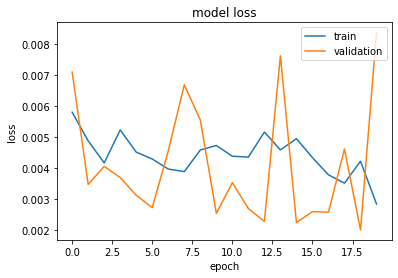

In [293]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [294]:
pred_model_3_y_test_std = model_3.predict(X_test_std)
pred_model_3_y_test = pred_model_3_y_test_std*(ymax-ymin) + ymin
pred_model_3_y_test.shape

(30005, 1)

In [295]:
rmse_lstm_3 = np.sqrt(mean_squared_error(y_test, pred_model_3_y_test))
print("RMSE of Stacked LSTM: ", rmse_lstm_3)
print("I.E. %.04f degree of mean error" % (rmse_lstm_3/math.pi*180))

RMSE of Stacked LSTM:  0.22192709782121378
I.E. 12.7155 degree of mean error


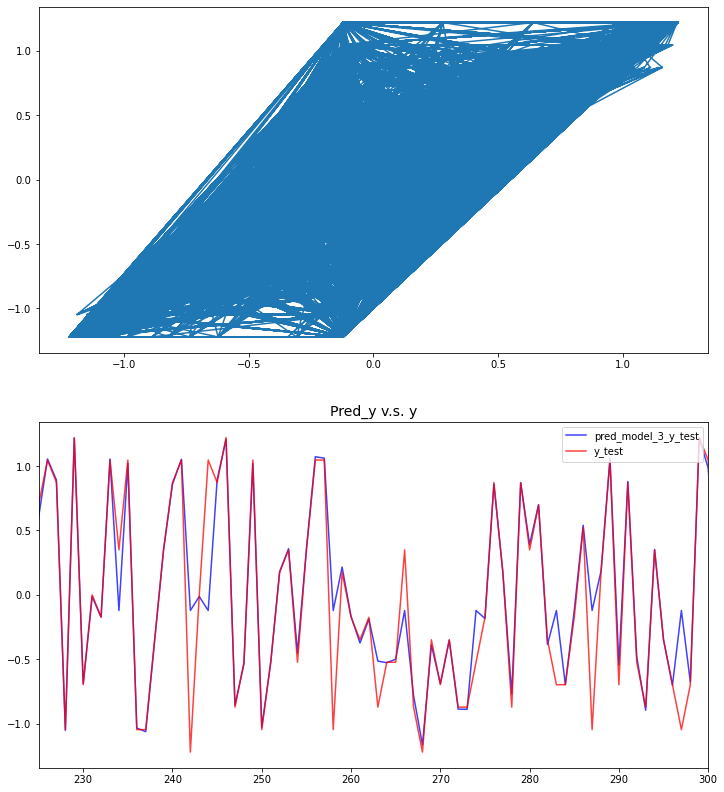

In [159]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_model_3_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_model_3_y_test.shape[0])], list(pred_model_3_y_test), color='b', alpha=0.75, label='pred_model_3_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"Pred_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='upper right')
ax_lst[1].set_xlim([225, 300])
plt.show()

## LSTM-Autoencoder
liuzm-DNN-DOA

In [4]:
feature_dim = 12
SF = 15

aec_x = Input(shape=(feature_dim, ))
aec1 = Dense(10, activation='linear')(aec_x)

aec_out = []
for i in range(SF):
    aec_out.append(Dense(feature_dim, activation='linear')(aec1))

AEC = Model(inputs=aec_x, outputs=aec_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
AEC.compile(optimizer=optimizer, loss=['mse' for i in range(SF)])
AEC.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           130         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           132         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 12)           132         dense_1[0][0]                    
____________________________________________________________________________________________

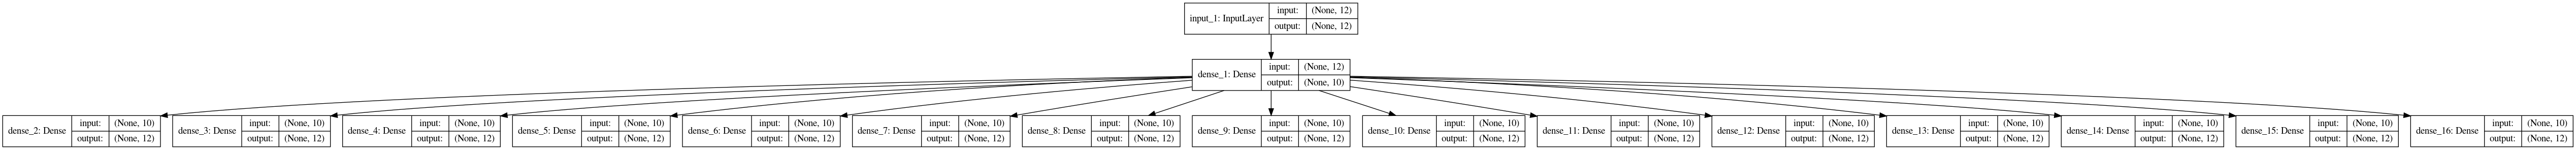

In [6]:
plot_model(
    AEC,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
X_AEC_train_std = np.multiply(X_train_std, y_AEC_train)

DeepAOANet

In [296]:
time_steps = 3
feature_dim = 20 #6

x0 = Input(shape=(time_steps, feature_dim))
l1 = LSTM(128, activation='relu', return_sequences=True)(x0)
l2 = LSTM(64, activation='relu', return_sequences=False)(l1)
h0 = RepeatVector(time_steps)(l2)
l3 = LSTM(64, activation='relu', return_sequences=True)(h0)
l4 = LSTM(128, activation='relu', return_sequences=True)(l3)
r0 = TimeDistributed(Dense(feature_dim))(l4)


LSTM_AE = Model(inputs=x0, outputs=r0)
LSTM_AE_optimizer = keras.optimizers.Adam(learning_rate=0.001)
LSTM_AE.compile(optimizer=LSTM_AE_optimizer, loss='mse')
LSTM_AE.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 128)            76288     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_16 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 20)             258

In [297]:
epochs = 30
batch_size = 128

history_lstm_ae = LSTM_AE.fit(X_train_std, X_train_std, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val_std, X_val_std))

Train on 60008 samples, validate on 60008 samples
Epoch 1/30
60008/60008 [==============================] - 9s 148us/step - loss: 0.0264 - val_loss: 0.0020
Epoch 2/30
60008/60008 [==============================] - 8s 128us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/30
60008/60008 [==============================] - 8s 131us/step - loss: 9.3606e-04 - val_loss: 8.1946e-04
Epoch 4/30
60008/60008 [==============================] - 8s 136us/step - loss: 7.7516e-04 - val_loss: 7.1230e-04
Epoch 5/30
60008/60008 [==============================] - 8s 132us/step - loss: 6.9228e-04 - val_loss: 6.7050e-04
Epoch 6/30
60008/60008 [==============================] - 8s 140us/step - loss: 6.3888e-04 - val_loss: 6.2507e-04
Epoch 7/30
60008/60008 [==============================] - 8s 141us/step - loss: 5.9931e-04 - val_loss: 5.7760e-04
Epoch 8/30
60008/60008 [==============================] - 9s 142us/step - loss: 5.4681e-04 - val_loss: 5.0430e-04
Epoch 9/30
60008/60008 [==============================

In [298]:
pred_X_test_std = LSTM_AE.predict(X_test_std, verbose=0)
print('---Predicted---')
print(np.round(pred_X_test_std, 4))
print('---Actual---')
print(np.round(X_test_std, 4))

---Predicted---
[[[ 9.072e-01  3.800e-03  2.964e-01 ...  4.969e-01  7.278e-01 -1.200e-03]
  [ 9.000e-04  4.600e-03  2.839e-01 ...  8.226e-01  9.159e-01 -2.400e-03]
  [ 8.970e-01 -1.400e-03  3.003e-01 ...  5.127e-01  7.464e-01  1.700e-03]]

 [[ 4.700e-03  1.000e-04  3.721e-01 ...  7.531e-01  4.164e-01 -6.000e-04]
  [ 3.700e-03  3.000e-04  3.677e-01 ...  7.593e-01  4.215e-01  0.000e+00]
  [ 3.700e-03  7.000e-04  3.705e-01 ...  7.589e-01  4.195e-01 -1.000e-04]]

 [[ 8.979e-01  2.000e-04  3.081e-01 ...  4.996e-01  7.446e-01  3.000e-04]
  [ 9.035e-01  1.600e-03  3.091e-01 ...  5.062e-01  7.476e-01 -3.000e-04]
  [ 8.916e-01  6.000e-04  3.072e-01 ...  5.074e-01  7.446e-01 -5.000e-04]]

 ...

 [[ 8.959e-01  2.000e-04  3.090e-01 ...  5.023e-01  7.394e-01  2.000e-04]
  [ 9.135e-01  1.600e-03  3.060e-01 ...  5.047e-01  7.460e-01 -1.000e-04]
  [ 8.934e-01  5.000e-04  3.071e-01 ...  5.049e-01  7.456e-01 -1.000e-04]]

 [[ 8.956e-01  3.000e-04  3.115e-01 ...  5.012e-01  7.413e-01  3.000e-04]
  [ 9.06

In [299]:
encoder = Model(inputs=x0, outputs=l2)
encoder.compile(optimizer='adam', loss='mse')
encoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 128)            76288     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________


In [300]:
# Predict both Train/Test data for further training the Regressor
pred_encoded_X_train_std = encoder.predict(X_train_std)
pred_encoded_X_test_std = encoder.predict(X_test_std)
pred_encoded_X_val_std = encoder.predict(X_val_std)
pred_encoded_X_test_std.shape

(30005, 64)

### Dense-regressor on Encoded R-features

In [301]:
def build_regressor(feature_dim = 64):
    
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(256, activation='relu')(x)
    h2 = Dense(512, activation='relu')(h1)
    h3 = Dense(256, activation='relu')(h2)
    h4 = Dense(128, activation='relu')(h3)
    r = Dense(1, activation='sigmoid')(h4)
    
    return Model(inputs=x, outputs=r)

model_4 = build_regressor(64)
Regressor_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_4.compile(optimizer=Regressor_optimizer, loss='mse')
model_4.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
Total params: 312,577
Trainable params: 312,577
Non-trainable params: 0
____________________________________________________

In [302]:
epochs = 30
batch_size = 128

history_model_4 = model_4.fit(pred_encoded_X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(pred_encoded_X_val_std, y_val_std))

Train on 60008 samples, validate on 60008 samples
Epoch 1/30
60008/60008 [==============================] - 2s 41us/step - loss: 0.0227 - val_loss: 0.0193
Epoch 2/30
60008/60008 [==============================] - 2s 31us/step - loss: 0.0181 - val_loss: 0.0130
Epoch 3/30
60008/60008 [==============================] - 2s 31us/step - loss: 0.0155 - val_loss: 0.0144
Epoch 4/30
60008/60008 [==============================] - 2s 32us/step - loss: 0.0126 - val_loss: 0.0064
Epoch 5/30
60008/60008 [==============================] - 2s 33us/step - loss: 0.0073 - val_loss: 0.0042
Epoch 6/30
60008/60008 [==============================] - 2s 34us/step - loss: 0.0077 - val_loss: 0.0191
Epoch 7/30
60008/60008 [==============================] - 2s 34us/step - loss: 0.0067 - val_loss: 0.0048
Epoch 8/30
60008/60008 [==============================] - 2s 33us/step - loss: 0.0078 - val_loss: 0.0069
Epoch 9/30
60008/60008 [==============================] - 2s 33us/step - loss: 0.0054 - val_loss: 0.0054
Epoch

In [303]:
pred_model_4_y_test_std = model_4.predict(pred_encoded_X_test_std)
pred_model_4_y_test = pred_model_4_y_test_std*(ymax-ymin) + ymin

rmse_model_4 = np.sqrt(mean_squared_error(y_test, pred_model_4_y_test))
print("RMSE of LSTM-AE + 4FC: ", rmse_model_4)
print("I.E. %.04f degree of mean error" % (rmse_model_4/math.pi*180))

RMSE of LSTM-AE + 4FC:  0.1491411455090072
I.E. 8.5452 degree of mean error


In [57]:
# Prepare unseen testing data
Xarr1.shape

(2230, 3, 6)

In [58]:
# Normalization
Xarr1_std = mmsc.transform(Xarr1.reshape(-1, Xarr1.shape[-1])).reshape(Xarr1.shape)
print(Xarr1_std.shape)

yarr1 = [item[0] for item in yarr1]
yarr1_std = (yarr1 - ymin)/(ymax-ymin)
print(yarr1_std.shape)

(2230, 3, 6)
(2230,)


In [79]:
# Save and Load models
import pickle

encoder_fc_tuple = (encoder, model_4)

pkl_filename = "encoder_fc_phs_tuple.pkl"
with open(join('checkpoints', pkl_filename), 'wb') as a_file:
    pickle.dump(encoder_fc_tuple, a_file)

In [88]:
pkl_filename = "encoder_fc_tuple.pkl"
with open(join('checkpoints', pkl_filename), 'rb') as a_file:
    encoder_cpy, model_4_cpy = pickle.load(a_file)
    
encoder_cpy.summary()
model_4_cpy.summary()


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3, 20)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 128)            76288     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               16640     
_________________________________

In [68]:
# Predict output of model_4(encoder(X_train/test))
pred_encoded_LSTM_AE_4FC_std = encoder.predict(Xarr1_std)
pred_LSTM_AE_4FC_std = model_4.predict(pred_encoded_LSTM_AE_4FC_std)

NameError: name 'Xarr1_std' is not defined

In [60]:
pred_LSTM_AE_4FC = pred_LSTM_AE_4FC_std*(ymax-ymin) + ymin

rmse_LSTM_AE_4FC = np.sqrt(mean_squared_error(yarr1, pred_LSTM_AE_4FC))
print("RMSE of (LSTM-AE + 4FC) upon unseen data X1: ", rmse_LSTM_AE_4FC)
print("I.E. %.04f degree of mean error" % (rmse_LSTM_AE_4FC/math.pi*180))

RMSE of (LSTM-AE + 4FC) upon unseen data X1:  1.1125852498220687
I.E. 63.7464 degree of mean error


### Build end-to-end Encoder+FC model
Perform poorer than two-stage inference

In [154]:
# Build encoder_fc model
fc1 = Dense(256, activation='relu')(l2)
fc2 = Dense(512, activation='relu')(fc1)
fc3 = Dense(256, activation='relu')(fc2)
fc4 = Dense(128, activation='relu')(fc3)
fc_out = Dense(1, activation='sigmoid')(fc4)

model_encoder_fc = Model(inputs=x0, outputs=fc_out)

Encoder_fc_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_encoder_fc.compile(optimizer=Encoder_fc_optimizer, loss='mse')
model_encoder_fc.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               3289

In [155]:
epochs = 50
batch_size = 128

history_model_encoder_fc = model_encoder_fc.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std, y_test_std))

Train on 117524 samples, validate on 39175 samples
Epoch 1/50
117524/117524 [==============================] - 8s 64us/step - loss: 0.0039 - val_loss: 2.3993e-04
Epoch 2/50
117524/117524 [==============================] - 7s 62us/step - loss: 1.9924e-04 - val_loss: 1.3411e-04
Epoch 3/50
117524/117524 [==============================] - 7s 56us/step - loss: 1.2737e-04 - val_loss: 1.1889e-04
Epoch 4/50
117524/117524 [==============================] - 7s 57us/step - loss: 9.7784e-05 - val_loss: 1.5343e-04
Epoch 5/50
117524/117524 [==============================] - 6s 55us/step - loss: 7.3972e-05 - val_loss: 6.3159e-05
Epoch 6/50
117524/117524 [==============================] - 7s 59us/step - loss: 7.4178e-05 - val_loss: 9.1304e-05
Epoch 7/50
117524/117524 [==============================] - 6s 54us/step - loss: 5.8779e-05 - val_loss: 6.0106e-05
Epoch 8/50
117524/117524 [==============================] - 7s 60us/step - loss: 5.9536e-05 - val_loss: 5.6628e-05
Epoch 9/50
117524/117524 [=======

In [156]:
pred_model_encoder_fc_y_test_std = model_encoder_fc.predict(X_test_std)
pred_model_encoder_fc_y_test = pred_model_encoder_fc_y_test_std*(ymax-ymin) + ymin

rmse_model_encoder_fc = np.sqrt(mean_squared_error(y_test, pred_model_encoder_fc_y_test))
print("RMSE of ENCODER-FC: ", rmse_model_encoder_fc)
print("I.E. %.04f degree of mean error" % (rmse_model_encoder_fc/math.pi*180))

RMSE of ENCODER-FC:  0.005444264712502533
I.E. 0.3119 degree of mean error


In [157]:
# Try unseen data X1
pred_ENCODER_FC_E2E_std = model_encoder_fc.predict(Xarr1)
pred_ENCODER_FC_E2E = pred_ENCODER_FC_E2E_std*(ymax-ymin) + ymin

rmse_ENCODER_FC_E2E = np.sqrt(mean_squared_error(yarr1, pred_ENCODER_FC_E2E))
print("RMSE [Rad] of (end-to-end ENCODER+FC) upon unseen data X1: ", rmse_ENCODER_FC_E2E)
print("I.E. %.04f degree of mean error" % (rmse_ENCODER_FC_E2E/math.pi*180))

RMSE [Rad] of (end-to-end ENCODER+FC) upon unseen data X1:  0.7433023721801533
I.E. 42.5881 degree of mean error


### SVR on Encoded R-features (Optional)

In [69]:
# SVR
svr_ae = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_ae.fit(pred_encoded_X_train_std, y_train)
svr_ae.score(pred_encoded_X_test_std, y_test)

0.9426798652526259

In [75]:
'''
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(pred_encoded_X_train_std, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
'''

"\nparams = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}\ngrid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)\ngrid.fit(pred_encoded_X_train_std, y_train)\nprint(grid.best_estimator_)\nprint(grid.best_score_)\n"

In [180]:
with open(join('checkpoints', 'svr_ae.pkl'), 'wb') as a_file:
    pickle.dump(svr_ae, a_file)

In [145]:
with open(join('checkpoints', 'svr_ae.pkl'), 'rb') as a_file:
    svr_ae = pickle.load(a_file)

In [70]:
pred_EncodeSVR_y_test = svr_ae.predict(pred_encoded_X_val_std)
rmse_svr_ae = np.sqrt(mean_squared_error(y_val, pred_EncodeSVR_y_test))
print("RMSE [Rad] for LSTM-AE + SVR:", rmse_svr_ae)
print("I.E. %.04f degree of mean error" % (rmse_svr_ae/math.pi*180))

RMSE [Rad] for LSTM-AE + SVR: 0.17454503691309395
I.E. 10.0007 degree of mean error


In [152]:
# Try unseen data X1
pred_SVR_AE = svr_ae.predict(pred_encoded_LSTM_AE_4FC_std)

rmse_SVR_AE = np.sqrt(mean_squared_error(yarr1, pred_SVR_AE))
print("RMSE [Rad] of (LSTM-AE + SVR) upon unseen data X1: ", rmse_SVR_AE)
print("I.E. %.04f degree of mean error" % (rmse_SVR_AE/math.pi*180))

RMSE [Rad] of (LSTM-AE + SVR) upon unseen data X1:  2.110344460674068
I.E. 120.9138 degree of mean error


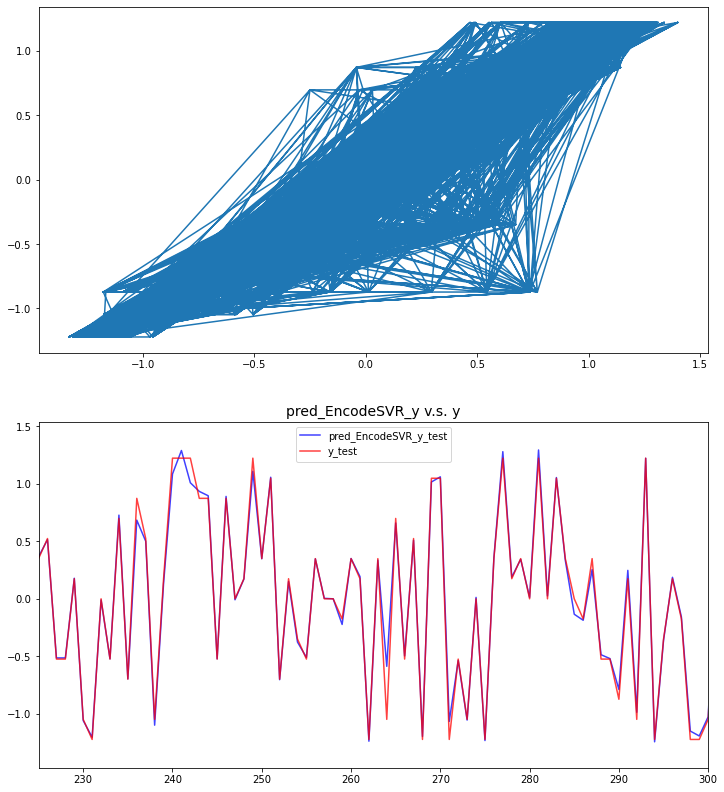

In [140]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_EncodeSVR_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_EncodeSVR_y_test.shape[0])], list(pred_EncodeSVR_y_test), color='b', alpha=0.75, label='pred_EncodeSVR_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"pred_EncodeSVR_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='best')
ax_lst[1].set_xlim([225, 300])
plt.show()

### Visualize CDF

In [71]:
y_err_series = pd.Series(abs(y_val - pred_EncodeSVR_y_test) / math.pi*180)

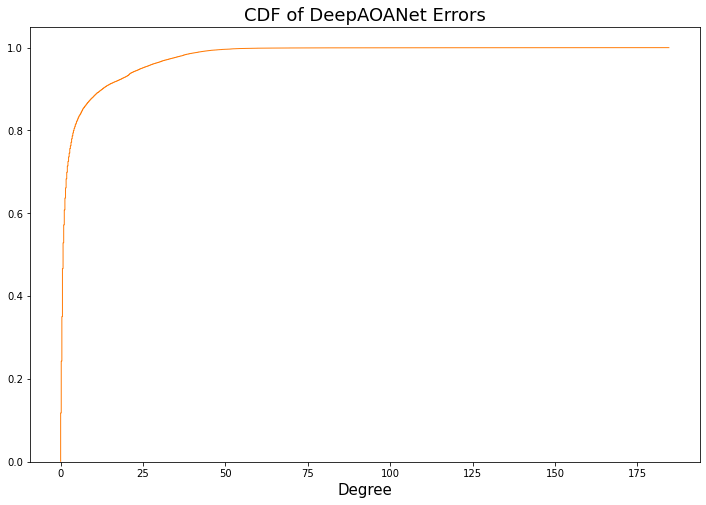

In [72]:
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
n, bins, patches = ax_hist.hist(y_err_series, density=True, cumulative = True, histtype='step', bins=1000, color='tab:orange')
patches[0].set_xy(patches[0].get_xy()[:-1])
ax_hist.set_title("CDF of DeepAOANet Errors", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
plt.show()

### Directly apply SVR on Rjk

In [73]:
# Xsingle equivalent to Xvec_clean
print(np.argwhere(np.isnan(yvec)), np.argwhere(np.isnan(yvec_clean)))

[[ 89651      0]
 [ 89652      0]
 [ 89653      0]
 [ 93042      0]
 [ 93043      0]
 [ 93044      0]
 [ 96433      0]
 [ 96434      0]
 [ 96435      0]
 [ 99824      0]
 [ 99825      0]
 [ 99826      0]
 [130343      0]
 [130344      0]
 [130345      0]
 [133734      0]
 [133735      0]
 [133736      0]
 [137125      0]
 [137126      0]
 [137127      0]
 [140516      0]
 [140517      0]
 [140518      0]] []


In [74]:
# repeat shuffle?
Xsingle = Xvec[~np.isnan(Xvec).any(axis=1)]
ysingle0 = yvec[~np.isnan(yvec).any(axis=1)]
ysingle = [item[0] for item in ysingle0]

In [81]:
yvec_clean.shape

(297504, 2)

In [82]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(Xvec_clean, yvec_clean[:,0], test_size=0.7, random_state=42)

In [84]:
svr_0 = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_0.fit(X_train0, y_train0)
svr_0.score(X_test0, y_test0)

0.7462810025375146

In [181]:
# Save SVR
with open(join('checkpoints', 'svr_0.pkl'), 'wb') as a_file:
    pickle.dump(svr_0, a_file)

In [ ]:
with open(join('checkpoints', 'svr_0.pkl'), 'rb') as a_file:
    svr_0 = pickle.load(a_file)

In [86]:
pred_SVR0_y_test = svr_0.predict(X_test0)
rmse0 = np.sqrt(mean_squared_error(y_test0, pred_SVR0_y_test))
print("RMSE for SVR0:", rmse0)
print("I.E. %.04f degree of mean error" % (rmse0/math.pi*180))

RMSE for SVR0: 0.36885143299303336
I.E. 21.1336 degree of mean error


In [ ]:
# Unseen X1/Xphs1
pred_SVR0_Xvec1_test = svr_0.predict(Xvec1)
rmse_SVR0_Xvec1 = np.sqrt(mean_squared_error(yvec1[:, 0], pred_SVR0_Xvec1_test))
print("RMSE for SVR0 on unseen data:", rmse_SVR0_Xvec1)
print("I.E. %.04f degree of mean error" % (rmse_SVR0_Xvec1/math.pi*180))

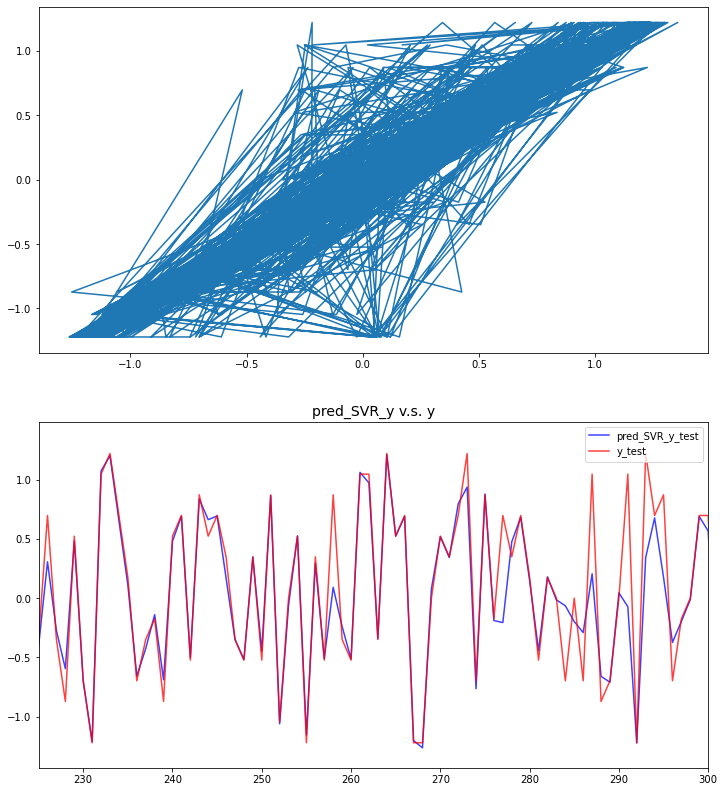

In [159]:
fig0 ,ax_lst0 = plt.subplots(2, 1,figsize=(12,14))
ax_lst0[0].plot(pred_SVR0_y_test[:2000], y_test0[:2000])
ax_lst0[1].plot([i for i in range(pred_SVR0_y_test.shape[0])], list(pred_SVR0_y_test), color='b', alpha=0.75, label='pred_SVR_y_test')
ax_lst0[1].plot(y_test0, color='red', alpha=0.75, label='y_test')
ax_lst0[1].set_title(f"pred_SVR_y v.s. y",fontsize=14)
ax_lst0[1].grid(False)
ax_lst0[1].legend(loc='best')
ax_lst0[1].set_xlim([225, 300])
plt.show()

# CDF

In [87]:
y_err_music_series = pd.Series(abs(y_test[i] / math.pi*180 - y_test_music[i]) for i in range(len(y_test)))

In [88]:
#y_err_lstm_ae_svr_series = pd.Series(abs(y_test - pred_EncodeSVR_y_test) / math.pi*180)

In [89]:
y_err_svr0_series = pd.Series(abs(y_test0 - pred_SVR0_y_test) / math.pi*180)

In [91]:
y_err_lstm_ae_fc_series = pd.Series(abs(y_val - pred_model_4_y_test.ravel()) / math.pi*180)

In [92]:
y_err_lstm_stacked_lstm_series = pd.Series(abs(y_val - pred_model_3_y_test.ravel()) / math.pi*180)

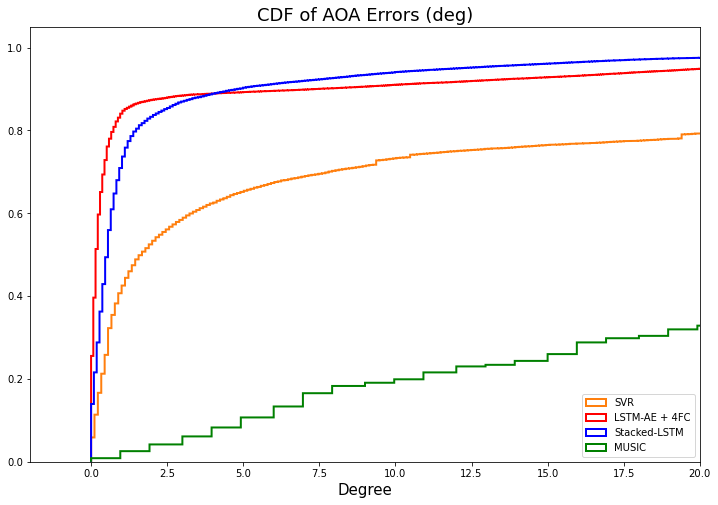

In [94]:
%matplotlib inline
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
'''
n, bins, patches = ax_hist.hist(y_err_lstm_ae_svr_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='LSTM-AE + SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
'''
n, bins, patches = ax_hist.hist(y_err_svr0_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
n2, bins2, patches2 = ax_hist.hist(y_err_lstm_ae_fc_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='red', linewidth=2, label='LSTM-AE + 4FC')
patches2[0].set_xy(patches2[0].get_xy()[:-1])
n3, bins3, patches3 = ax_hist.hist(y_err_lstm_stacked_lstm_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='b', linewidth=2, label='Stacked-LSTM')
patches3[0].set_xy(patches3[0].get_xy()[:-1])
n4, bins4, patches4 = ax_hist.hist(y_err_music_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='g', linewidth=2, label='MUSIC')
patches4[0].set_xy(patches4[0].get_xy()[:-1])

ax_hist.set_title("CDF of AOA Errors (deg)", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
ax_hist.set_xlim(-2, 20)
ax_hist.legend(loc='lower right')

fig_hist.savefig(join('doc', 'CDF_X_105.png'), facecolor="w", bbox_inches='tight')
plt.show()

# Validation
### (1) Unseen NLOS Data [-45, 0, 45]

In [81]:
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']
new_col = ['r12', 'r13', 'r14', 'r23', 'r24', 'r34']
# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-05

In [82]:
test_dict = {}
test_dir = join('data_1606', 'test')

for filename in os.listdir(test_dir):
    if filename.startswith("test_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[- float(filename[6:-4])] = aoa_Rjk
    elif filename.startswith("test_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[float(filename[5:-4])] = aoa_Rjk

In [83]:
test_sig = {}
test_sig_index = {}

for key in test_dict.keys():
    test_dict[key]['theta'] = key * math.pi / 180
    test_sig_index[key] = (test_dict[key][abs(test_dict[key]['field.data2']) < field_thres].index)
    test_sig[key] = test_dict[key].iloc[test_sig_index[key], :]

Xtest = pd.concat([test_sig[rad] for rad in test_dict.keys()], \
                 keys=[rad for rad in test_dict.keys()], names=['Series name', 'Row ID'])
Xtest['music'] = pd.Series([0] * len(Xtest.index))

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [89]:
Xtest.shape

(3111, 22)

In [90]:
# CREATE: If using R_phase as input feature
Xphs_test2, Xamp_test2 = [], []
for item in [Xtest]:
    phs, amp = create_Xphs_Xamp(item)
    Xphs_test2.append(phs)
    Xamp_test2.append(amp)
    
Xphs_test2[0]

r12       r13       r14       r23  r24       r34  \
Series name Row ID                                                     
-45.0       0       0.0 -0.584400 -2.562005 -1.698066  0.0 -2.149339   
            1       0.0 -0.435424 -2.517031 -1.727634  0.0 -1.703768   
            2       0.0 -1.983908 -2.656720 -1.502667  0.0  0.189015   
            3       0.0 -0.540016 -2.599287 -1.844297  0.0 -2.151937   
            15      0.0 -0.457718 -2.506565 -1.714339  0.0 -2.113907   
...                 ...       ...       ...       ...  ...       ...   
 45.0       1700    0.0 -0.680340 -2.799323 -0.808793  0.0 -2.554681   
            1701    0.0 -0.235561 -2.661797 -0.823952  0.0 -2.332732   
            1702    0.0  0.092232 -2.675180 -0.743071  0.0 -2.680688   
            1703    0.0 -0.340383 -2.803112 -0.903844  0.0 -2.574776   
            1704    0.0 -0.114608 -2.746498 -0.858374  0.0 -2.731961   

                       theta  music  
Series name Row ID                   
-45.0       0      -0.785398    NaN  
            1      -0.785398    NaN  
            2      -0.785398    NaN  
            3      -0.785398    NaN  
            15     -0.785398    NaN  
...                      ...    ...  
 45.0       1700    0.785398    NaN  
            1701    0.785398    NaN  
            1702    0.785398    NaN  
            1703    0.785398    NaN  
            1704    0.785398    NaN  

[3111 rows x 8 columns]

In [93]:
# SPLIT
for item in Xphs_test2:
    Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(item, aoa_gt_series=range(-45, 90, 45), \
                                                                   feature_space=6)
    
Xtest_arr.shape

(2949, 3, 6)

In [105]:
ytest_vec.shape

(3111, 2)

In [94]:
# SHUFFLE
X_train_null, X_test2, y_train_null, y_test2 = train_test_split(Xtest_arr, ytest_lst2, test_size=0.9, random_state=42)

In [106]:
print(X_test2.shape, len(y_test2))

(2655, 3, 6) 2655


In [98]:
# Normalization
X_test2_std = mmsc.transform(X_test2.reshape(-1, X_test2.shape[-1])).reshape(X_test2.shape)

y_test2_lst = [item[0] for item in y_test2]
y_test2_lst_std = (y_test2_lst - ymin)/(ymax-ymin)

In [99]:
# Stacked LSTM
pred_X_test2_std = model_3.predict(X_test2_std)
pred_X_test2 = pred_X_test2_std*(ymax - ymin) + ymin

pred_X_test2_std.shape

(2655, 1)

In [100]:
rmse_lstm_model_3_test2 = np.sqrt(mean_squared_error(y_test2_lst, pred_X_test2_std))
print("RMSE of Stacked LSTM: ", rmse_lstm_model_3_test2)
print("I.E. %.04f degree of mean error" % (rmse_lstm_model_3_test2/math.pi*180))

RMSE of Stacked LSTM:  0.6765697700547708
I.E. 38.7646 degree of mean error


In [101]:
# Encoder-SVR
pred_EncoderSVR_ytest_lst = svr_ae.predict(encoder.predict(X_test2_std))

rmse_EncoderSVR = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderSVR_ytest_lst))
print("RMSE of LSTM-Encoder + SVR: ", rmse_EncoderSVR)
print("I.E. %.04f degree of mean error" % (rmse_EncoderSVR/math.pi*180))

NameError: name 'svr_ae' is not defined

In [102]:
# Encoder-FC
pred_EncoderFC_ytest_lst = model_4.predict(encoder.predict(X_test2_std))

rmse_EncoderFC = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderFC_ytest_lst))
print("RMSE of LSTM-Encoder + FC: ", rmse_EncoderFC)
print("I.E. %.04f degree of mean error" % (rmse_EncoderFC/math.pi*180))

RMSE of LSTM-Encoder + FC:  0.6500714798665922
I.E. 37.2464 degree of mean error


In [108]:
# DirectSVR
#X_train_null, X_test2vec, y_train_null, y_test2vec = train_test_split(Xtest_vec, ytest_vec, test_size=0.9, random_state=42)
pred_SVR_0_X_test2 = svr_0.predict(X_test2[:, 0, :])
rmse_svronly2 = np.sqrt(mean_squared_error(y_test2_lst, pred_SVR_0_X_test2))
print("RMSE for SVR-Only:", rmse_svronly2)
print("I.E. %.04f degree of mean error" % (rmse_svronly2/math.pi*180))

RMSE for SVR-Only: 1.0544157098489537
I.E. 60.4136 degree of mean error


### (2) Test with UNSEEN data